## Data Analysis

Author: A. Zarkali
Date: 22nd Feb 2019
Purpose: Completes all data analysis and plots for Priors Experiment

### Import libraries and load data

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import shapiro
from math import exp,sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scikit_posthocs as sp
import seaborn as sns


# Enable inline plotting
%matplotlib inline

In [2]:
# Create data frame for the whole dataset
df = pd.read_excel(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\01_PriorsAmbiguousStimul\CombinedDataPriors.xlsx")

In [3]:
# Create dataframe for the subplots
group_df = pd.read_excel(r"C:\Users\Angelika\Dropbox\PhD\EXPERIMENTS\01_PriorsAmbiguousStimul\SplitAnalysis.xlsx")

### Calculate Signal Detection theory measures

Here, we calculate d', c and beta for each subject.

    Hit: Signal present and response
    Miss: Signal present and no response
    False Alarm: No signal and response
    Correct Rejection: No signal and no response

In our experiment, signal is considered the presence of a person in the two-tone "Mooney" image. 

    HR: Hit Rate, the probability of a signal being detected. HR = Hit when Signal/Signals
    FA: False Alarm Rate, the probablitiy of response in the absence of signal. FA = Hits when no Signal/No Signals


To avoid infinite values, we replace 0 and 1 values with half FA or half HR accordingly.

In [4]:
Z = norm.ppf

#Flooring on ceilings:
halfH = 0.5 / 30 #(30 = hits + misses when signal present)
halfFA = 0.5 / 30 #(30 = false alarms + correct rejections)
new = 1 - halfH

#Find and replace HR and FA ==1 to avoid infinite values
df["MooneyPreH"] = df["MooneyPreH"].replace(1, new)
df["MooneyPreFA"] = df["MooneyPreFA"].replace(1, new)
df["MooneyPostH"] = df["MooneyPostH"].replace(1, new)
df["MooneyPostFA"] = df["MooneyPostFA"].replace(1, new)
#Find and replace HR and FA ==0 to avoid infinite values
df["MooneyPreH"] = df["MooneyPreH"].replace(0, halfH)
df["MooneyPreFA"] = df["MooneyPreFA"].replace(0, halfFA)
df["MooneyPostH"] = df["MooneyPostH"].replace(0, halfH)
df["MooneyPostFA"] = df["MooneyPostFA"].replace(0, halfFA)

#Calculate d prime
df["PreD"] = Z(df.MooneyPreH) - Z(df.MooneyPreFA)
df["PostD"] = Z(df.MooneyPostH) - Z(df.MooneyPostFA)
df["ImprovD"] = df.PostD - df.PreD

#Calculate beta
# df["PreBeta"] = exp((Z(df.MooneyPreFA) **2 - Z(df.MooneyPreH) **2)/2)
# df["PostBeta"] = exp(Z((df.MooneyPostFA)(df.MooneyPostFA)) - (Z(df.MooneyPostH)(df.MooneyPostH))/2)
# df["ImprovBeta"] = df.PostBeta - df.PreBeta

#Calculate c
df["PreC"] = - (Z(df.MooneyPreH) + Z(df.MooneyPreFA))/2
df["PostC"] = - (Z(df.MooneyPostH) + Z(df.MooneyPostFA))/2
df["ImprovC"] = df.PostC - df.PreC
                    
#Calculate Ad
df["PreAd"] = norm.cdf(df["PreD"]/sqrt(2))
df["PostAd"] = norm.cdf(df["PostD"]/sqrt(2))
df["ImprovAd"] = df.PostAd - df.PreAd

#Calculate Change in FA and HR
df["ImprovH"] = df.MooneyPostH - df.MooneyPreH
df["ImprovFA"] = df.MooneyPostFA - df.MooneyPreFA

##### Define function for calculating effect sizes

Hedges g for parametric test (t-test)
Correlation coefficient r for non-parametric (Mann-Whitney)

References:
- Robert Rosenthal. The hand-book of research synthesis, chapter Parametric measures of effect size, pages 231–244. New York, NY: Russel Sage Foundation, 1994. 
- Larry Hedges and Ingram Olkin. Journal of Educational Statistics, chapter Statistical Methods in Meta-Analysis. Volume 20. Academic Press, Inc., 1985, 10.2307/1164953.

In [5]:
from numpy import std, mean, sqrt

# Hedges g:
def hedges(x,y,t):
    nx = len(x)
    ny = len(y)
    d = t*(sqrt(1/nx + 1/ny))
    g = d*(1 - 3/(4*(nx + ny - 9)))
    return g

In [6]:
# Correlation r:
def corcoef(x,y,u):
    m_u = len(x)*len(y)/2
    sigma_u = np.sqrt(len(x)*len(y)*(len(x)+len(y)+1)/12)
    z = (u - m_u)/sigma_u
    return z/np.sqrt(len(x)+len(y))

### Dataset descriptive statistics

Here we explore the data split per our three population groups and perform visual and statistical normality tests. 


First we group the dataframe according to PD diagnosis: 

    0 healthy controls, 1 PD/DLB non hallucinators, 2 PD/DLB hallucinators
    
and export mean and sd of the three group across all variables in csv. 

In [8]:
# Export descriptive statistics of the dataset grouped by PD diagnosis
groupdf = df.groupby("PD")
# groupdf.mean().reset_index().to_csv("GroupedMean.csv")
# groupdf.std().reset_index().to_csv("GroupedSD.csv")
# df.to_csv("Edit.csv")

##### Normality tests

Visual inspection of data distribution

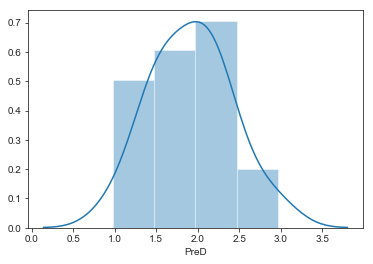

In [5]:
# Serially inspect each dependent variable (d', percentage correct, reaction time, etc) 
                                        #to check distribution across the dataset
df_PDonly = df[df.PD == 1] # only PD/DLB participants without hallucinations
df_VHonly = df[df.PD == 2] # only PD/DLB participants with hallucinations
df_Controlonly = df[df.PD == 0] # only controls

sns.set_style("ticks")
Plot = sns.distplot(df_Controlonly["PreD"].dropna())
                    
# Change to the df_PD database if want to 

Quantitative test: Shapiro Wilk

If p >0.05, then the data has a Gaussian distribution

In [103]:
#Shapiro-Wilk test
#testdf = df[df.SmellTest.notnull()] # to drop NA values in specific column
variable = df["ImprovD"].dropna()
stat, p = shapiro(variable)
print(stat,p)

0.963969349861145 0.08746964484453201


### Whole cohort performance comparison

Here we compare the performance in terms of d'prime, percentage correct, RT and criterion across the whole cohort

In [17]:
# t test
v1 = df.MooneyPostCorrect #Change variable with other variables sequentially
v2 = df.MooneyPreCorrect #Change variable with other variables sequentially

stats.ttest_ind(v1, v2, nan_policy="omit")

Ttest_indResult(statistic=4.119831663762788, pvalue=7.289739212828017e-05)

In [11]:
# effect size hedges
hedges(df.MooneyPostCorrect,df.MooneyPreCorrect, 4.12) # need to manually enter the t test from above 
                                                        # as the last variable

0.7662342322522921

In [108]:
# Mann-whitney test
# Compare performance in pre/post HR and FA in whole cohort
stats.mannwhitneyu(df.MooneyPostH, df.MooneyPreH)

MannwhitneyuResult(statistic=1140.0, pvalue=0.002848405798545483)

In [13]:
# effect size r
corcoef(df.MooneyPostH, df.MooneyPostH, 1150)

-0.25185503541861093

And testing each individual group for performance improvement

In [10]:
# t test
df_PDonly = df[df.PD == 1] # only PD/DLB participants without hallucinations
df_VHonly = df[df.PD == 2] # only PD/DLB participants with hallucinations
df_Controlonly = df[df.PD == 0] # only controls

v1 = df_PDonly.ImprovH #Change variable with other variables sequentially
v2 = df_VHonly.ImprovH #Change variable with other variables sequentially

stats.ttest_ind(v1, v2, nan_policy="omit")

Ttest_indResult(statistic=-1.3516884413994559, pvalue=0.18514666978625388)

Check for differences between DLB and non DLB participants

In [6]:
# Compare DLB with the rest
df_totalDLB = df[df.DLB == 1]
df_DLBVH = df[(df.DLB == 1) & (df.PD == 2)]
df_DLBonly = df[(df.DLB == 1) & (df.PD == 1)]
df_PDVHonly = df[(df.PD == 2) & (df.DLB == 0)]
df_PDnonVHonly = df[(df.PD == 1) & (df.DLB == 0)]
df_PD = df[(df.DLB != 1) & (df.PD !=0)]

v1 = df_DLBVH.PreD
v2 = df_PDVHonly.PreD
stats.ttest_ind(v1, v2, nan_policy="omit")

Ttest_indResult(statistic=-0.2427321960194433, pvalue=0.8115006573309012)

In [16]:
df_PDnonVHonly.ImprovD.mean()

0.26822555030450546

In [145]:
# t test excluding DLB
v1 = df_totalDLB.LEDD #Change variable with other variables sequentially
v2 = df_PD.LEDD #Change variable with other variables sequentially

stats.ttest_ind(v1, v2, nan_policy="omit")

Ttest_indResult(statistic=-0.30204294181520097, pvalue=0.7644069191529207)

In [168]:
# Mann Whitney test excluding DLB
v1 = df_DLBVH.HADSdepression
v2 = df_PDVHonly.HADSdepression

stats.mannwhitneyu(v1, v2)

MannwhitneyuResult(statistic=20.0, pvalue=0.47396094181116477)

In [124]:
df_PD.MMSE.mean()

28.875

In [22]:
# Miami Correlation excluding DLB (hallucinators only)

X = df_PDVHonly["ImprovD"]
y = df_PDVHonly["MiamiVH"]

# Note the difference in argument order
model = sm.OLS(y, X, missing='drop').fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

C:\Users\Angelika\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                MiamiVH   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     39.46
Date:                Wed, 29 May 2019   Prob (F-statistic):           2.83e-05
Time:                        21:11:03   Log-Likelihood:                -33.371
No. Observations:                  14   AIC:                             68.74
Df Residuals:                      13   BIC:                             69.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ImprovD        6.2346      0.993      6.282      0.000       4.090       8.379
==============================================================================
Omnibus:                       11.581   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                7.345
Skew:                          -1.437   Prob(JB):                       0.0254
Kurtosis:                       5.083   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Univariate Analysis all groups

Firstly, we compare all 3 study groups in terms of demographics and performance in clinical assessments and experimental task.

Normally distributed variables: ANOVA with post hoc Tukey test

Non normally distributed variables: Kruskall Wallis test with post hoc Dunn's tect

###### ANOVA 
For normally distributed variables

In [84]:
# ANOVA test:
variable = df.ImprovD # substitute variable sequentially to test all continuous variables
group = df.PD

anova = ols("variable ~ C(group)", data=df).fit()  
anova.summary()

# Prob(F-statistic): overall p- value
# Intercept: first variable group (for example in df.PD this is 0/control)
# R-squared: effect size

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               variable   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     3.184
Date:                Wed, 29 May 2019   Prob (F-statistic):             0.0493
Time:                        19:56:26   Log-Likelihood:                -29.285
No. Observations:                  57   AIC:                             64.57
Df Residuals:                      54   BIC:                             70.70
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4030      0.093      4.337      0.000       0.217       0.589
C(group)[T.1]    -0.2056      0.131     -1.565      0.123      -0.469       0.058
C(group)[T.2]     0.1354      0.137      0.988      0.328      -0.139       0.410
==============================================================================
Omnibus:                        2.640   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.050
Skew:                           0.311   Prob(JB):                        0.359
Kurtosis:                       2.309   Cond. No.                         3.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### Post hoc Tukey test
Returns a Numpy ndarray where 0 is False (not significant), 1 is True (significant), and -1 is for diagonal elements.
Significance level set at p=0,05

In [117]:
# Post hoc tukey test for ANOVA 
variable = df.ImprovD # substitute variable sequentially to test all continuous variables following ANOVA
group = df.PD
sp.posthoc_tukey_hsd(variable, group, alpha=0.05)

array([[-1,  0,  1],
       [ 0, -1,  0],
       [ 1,  0, -1]])

###### Kruskal Wallis test
For non normally distributed variables

In [62]:
# Kruskal Wallis H test:
stats.kruskal(df.MooneyPreRT, df.PD, nan_policy="omit")
# substitute first variable sequentially to test all non-continuous variables

KruskalResult(statistic=85.96714018108025, pvalue=1.829505711085628e-20)

###### Post hoc Nemenyi test
Returns an array of p values between group comparisons

In [7]:
# Nemenyi's post hoc test for Kruskal Wallis
sp.posthoc_nemenyi(df, val_col="MooneyPreRT", group_col="PD", sort=True)
# substitute variable sequentially to test all continuous variables following Kruskal Wallis

,0,1,2
0,-1.000000,0.908455,0.213907
1,0.908455,-1.000000,0.409546
2,0.213907,0.409546,-1.000000


##### Check for ceiling and floor effect

We used Levene's test of variance to test whether variance was significantly different in one of the three groups. 
Null hypothesis is that all input samples are from populations with equal variances.

In [9]:
df_PDonly = df[df.PD == 1] # only PD/DLB participants without hallucinations
df_VHonly = df[df.PD == 2] # only PD/DLB participants with hallucinations
df_Controlonly = df[df.PD == 0] # only controls

# Check for ceiling/floor effect
stats.levene(df_PDonly.PostD, df_Controlonly.PostD, df_VHonly.PostD)

LeveneResult(statistic=0.7657098153036125, pvalue=0.4699856090543062)

#### Clinical population comparison

Then we compare the two clinical population groups (PD/DLB with and without hallucinations) 
for variables specific to patients with PD/DLB.

    Continuous normally distributed variables: t-test
    Non normally distributed variables: Mann-Whitney test

In [25]:
# t test
df_PDonly = df[df.PD == 1] # only PD/DLB participants without hallucinations
df_VHonly = df[df.PD == 2] # only PD/DLB participants with hallucinations
df_Controlonly = df[df.PD == 0] # only controls

v1 = df_PDonly.ImprovD #Change variable with other variables sequentially
v2 = df_VHonly.ImprovD #Change variable with other variables sequentially

stats.ttest_ind(v1, v2, nan_policy="omit")

Ttest_indResult(statistic=-2.3493534038456656, pvalue=0.024577561325875897)

In [62]:
# effect size Hedges
hedges(df_PDonly.ImprovFA, df_VHonly.ImprovFA,2.19) #need to input the t statistic from above

0.7030949742988789

In [4]:
# Mann Whitney test
df_PDonly = df[df.PD == 1] # only PD/DLB participants without hallucinations
df_VHonly = df[df.PD == 2] # only PD/DLB participants with hallucinations
df_Controlonly = df[df.PD == 0] # only controls

v1 = df_VHonly.MooneyPostH
v2 = df_PDonly.MooneyPostH

stats.mannwhitneyu(v1, v2)

MannwhitneyuResult(statistic=144.5, pvalue=0.22101557775009462)

In [123]:
# effect size r
corcoef(df_VHonly.MooneyPreFA, df_PDonly.MooneyPreFA, 113.5) #need to input the U statistic from above

-0.28307854322609766

### Hallucinations subgroup

Here we compared improvement in d' in patients with different forms and severity of hallucinations.

In [69]:
# # Creat a dataframe with only clinical groups (drop controls)
# Drop controls
df_PD = df[df.PD != 0]
df_PD.reset_index()
#df_PD.tail(1)

,VIPDNo,DateTested,Age,DOB,Gender,Handedness,PD,DLB,LEDD,CHEI,...,PostD,ImprovD,PreC,PostC,ImprovC,PreAd,PostAd,ImprovAd,ImprovH,ImprovFA
53,136,2019-01-28,65,1954-04-16,1,1,1,0,0.0,0,...,2.804512,0.237086,0.55471,0.436168,-0.118543,0.965272,0.976321,0.011049,0.066,0.0


In [5]:
# Severity of Hallucinations as per the Miami J Questionnaire score
df_noVH=df[df.PD !=2]
X = df_noVH["PreD"]
y = df_noVH["ImprovD"]

# Note the difference in argument order
model = sm.OLS(y, X, missing='drop').fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

# Prob(F-statistic): overall p- value
# Intercept: first variable group (for example in df.PD this is 0/control)
# R-squared: effect size

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ImprovD   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     15.07
Date:                Mon, 03 Jun 2019   Prob (F-statistic):           0.000389
Time:                        16:28:28   Log-Likelihood:                -23.775
No. Observations:                  40   AIC:                             49.55
Df Residuals:                      39   BIC:                             51.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PreD           0.1376      0.035      3.882      0.000       0.066       0.209
==============================================================================
Omnibus:                        1.483   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                1.113
Skew:                          -0.146   Prob(JB):                        0.573
Kurtosis:                       2.237   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [179]:
# Severity of Hallucinations as per the Miami J Questionnaire score only in Hallucinators

X = df_VHonly["ImprovD"]
y = df_VHonly["MiamiVH"]

# Note the difference in argument order
model = sm.OLS(y, X, missing='drop').fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

NameError: name 'df_VHonly' is not defined

And the type of hallucinations (qualitative)

In [23]:
# Split of improvement in D as per VH type

# ANOVA test:
anova = ols("ImprovD ~ C(VH)", data=df_PD).fit()  #Change Age with other variables sequentially
anova.summary()

# Prob(F-statistic): overall p- value
# Intercept: first variable group (for example in df.PD this is 0/control)
# R-squared: effect size

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ImprovD   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     2.559
Date:                Thu, 04 Apr 2019   Prob (F-statistic):             0.0718
Time:                        19:19:06   Log-Likelihood:                -19.936
No. Observations:                  37   AIC:                             47.87
Df Residuals:                      33   BIC:                             54.32
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6105      0.139      4.396      0.000       0.328       0.893
C(VH)[T.Formed]       0.0582      0.289      0.201      0.842      -0.530       0.646
C(VH)[T.No]          -0.4131      0.170     -2.429      0.021      -0.759      -0.067
C(VH)[T.Provoked]    -0.3500      0.260     -1.347      0.187      -0.879       0.179
==============================================================================
Omnibus:                        0.853   Durbin-Watson:                   2.489
Prob(Omnibus):                  0.653   Jarque-Bera (JB):                0.827
Skew:                           0.141   Prob(JB):                        0.661
Kurtosis:                       2.324   Cond. No.                         5.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Multivariate Analysis

Correcting for difference in the LBD/VH and LBD non VH population.

Variables that differed between these groups: Hooper, HADSdepression, UPDRS.

In [101]:
X = df_PD[["MiamiVH", "PelliRobsonBL", "StroopWordTime","HADSdepression", "UPDRS"]]
y = df_PD["ImprovD"]

# Note the difference in argument order
X = sm.add_constant(X)
multi_model = sm.OLS(y, X, missing='drop').fit()

# Print out the statistics
multi_model.summary()

# Prob(F-statistic): overall p- value
# Intercept: first variable group (for example in df.PD this is 0/control)
# R-squared: effect size

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ImprovD   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     2.285
Date:                Fri, 05 Apr 2019   Prob (F-statistic):             0.0733
Time:                        10:41:39   Log-Likelihood:                -14.985
No. Observations:                  34   AIC:                             41.97
Df Residuals:                      28   BIC:                             51.13
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2267      0.800     -0.283      0.779      -1.866       1.413
MiamiVH            0.0768      0.032      2.415      0.023       0.012       0.142
PelliRobsonBL      0.2422      0.412      0.588      0.561      -0.601       1.085
StroopWordTime    -0.0114      0.009     -1.202      0.239      -0.031       0.008
HADSdepression    -0.0378      0.035     -1.076      0.291      -0.110       0.034
UPDRS              0.0107      0.006      1.789      0.084      -0.002       0.023
==============================================================================
Omnibus:                        0.096   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.953   Jarque-Bera (JB):                0.035
Skew:                           0.041   Prob(JB):                        0.982
Kurtosis:                       2.865   Cond. No.                         682.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
X = df_VHonly[["MiamiVH","LEDD","PelliRobsonBL","MMSE","Hooper","UPDRS", "HADSdepression", "StroopWordTime"]]
y = df_VHonly["ImprovD"]

# Note the difference in argument order
X = sm.add_constant(X)
multi_model = sm.OLS(y, X, missing='drop').fit()

# Print out the statistics
multi_model.summary()

# Prob(F-statistic): overall p- value
# Intercept: first variable group (for example in df.PD this is 0/control)
# R-squared: effect size

C:\Users\Angelika\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ImprovD   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     3.063
Date:                Fri, 05 Apr 2019   Prob (F-statistic):             0.0790
Time:                        10:37:19   Log-Likelihood:                 3.9912
No. Observations:                  16   AIC:                             10.02
Df Residuals:                       7   BIC:                             16.97
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.3700      2.191     -1.538      0.168      -8.550       1.810
MiamiVH            0.1078      0.042      2.549      0.038       0.008       0.208
LEDD              -0.0004      0.000     -0.987      0.357      -0.001       0.001
PelliRobsonBL      1.3122      0.485      2.705      0.030       0.165       2.459
MMSE               0.1098      0.074      1.477      0.183      -0.066       0.286
Hooper            -0.0820      0.031     -2.632      0.034      -0.156      -0.008
UPDRS              0.0188      0.008      2.496      0.041       0.001       0.037
HADSdepression    -0.0201      0.042     -0.481      0.645      -0.119       0.079
StroopWordTime    -0.0193      0.010     -1.882      0.102      -0.043       0.005
==============================================================================
Omnibus:                        3.350   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                2.168
Skew:                          -0.899   Prob(JB):                        0.338
Kurtosis:                       2.851   Cond. No.                     1.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Plots -  Whole Dataset

Firstly plot the improvement in percentage correct in all three groups: 
    0:Controls, 1:PD non hallucinations, 2: PD/DLB with hallucinations

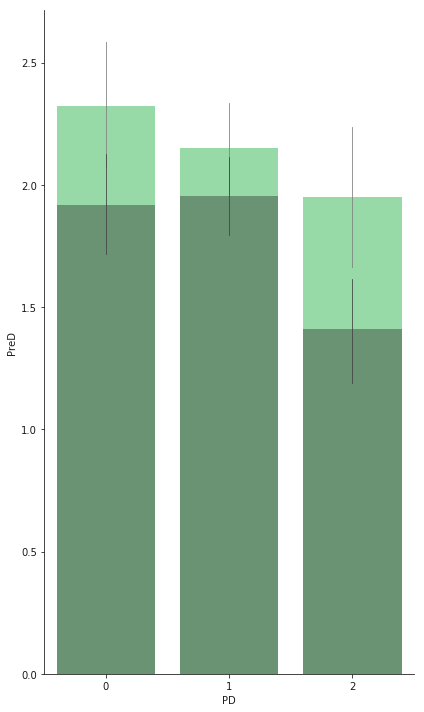

In [25]:
# Combined bar plotd' before and after in all groups

# Plot the after d'
sns.set_color_codes("pastel")
fig = sns.catplot(x="PD", y="PostD", data=df, kind="bar", label="Post", color="g", ci=95, errcolor="grey", 
                  errwidth=0.8,  height=10, aspect=0.6)

# Plot the before d'
sns.set_color_codes("deep")
fig = sns.barplot(x="PD", y="PreD", data=df, label="Pre", color="g", ci=95, errwidth=0.8, saturation=0.5)

# Add a legend and informative axis label
sns.despine(left=False, bottom=False)

fig = fig.get_figure()
fig.savefig("DAll.png")

### Plots - Clinical groups (PD/DLB with and without hallucinations) before-after blocks

First we plot the changes in percentage correct in patients with PD/DLB and hallucinations and those with PD/DLB without hallucinations

In [9]:
# Drop controls
dfPD = group_df[group_df.PD != "Control"]

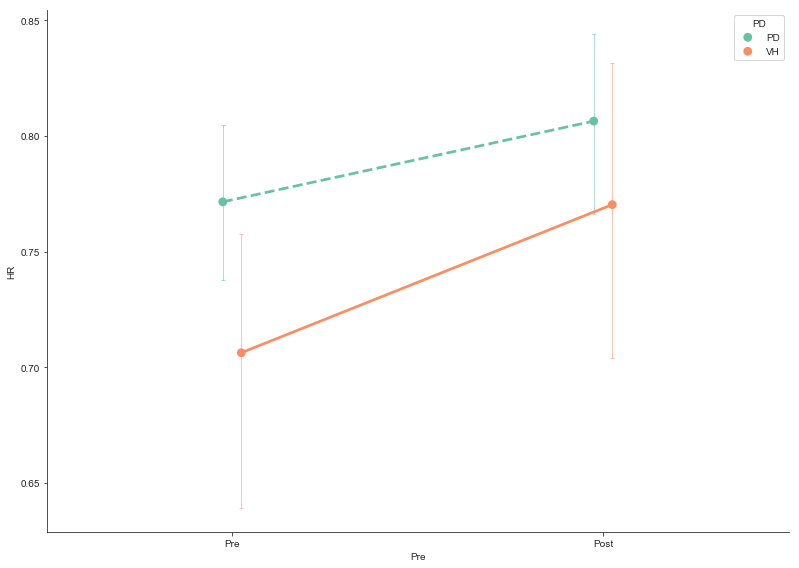

In [28]:
sns.set_style("ticks")
# colours = ["grey", "grey/blue"]
fig = sns.catplot(x="Pre", y="Mooney%Correct", kind="point", hue="PD", scale=1, dodge=True, 
                  linestyles=["--", "-"], errwidth=0.5, legend_out=False, data=dfPD, capsize=0.01, 
                  palette="Set2", ci=95, height=8, aspect=1.4)

# fig = fig.get_figure()
fig.savefig("Change%Correct.png")

In [261]:
# colours = ["grey", "grey/blue"]
# fig = sns.catplot(x="PD", y="Mooney%Correct", kind="box", linewidth=0.5, hue="Pre%Correct", legend_out=False, 
#                   data=dfPD, fliersize=2, palette=sns.xkcd_palette(colours), ci="sd", height=8, aspect=1.0)
# # fig = fig.get_figure()
# fig.savefig("Change%Correct.png")

Plot change in ReactionTime in patients with PD/DLB and hallucinations and those with PD/DLB without hallucinations

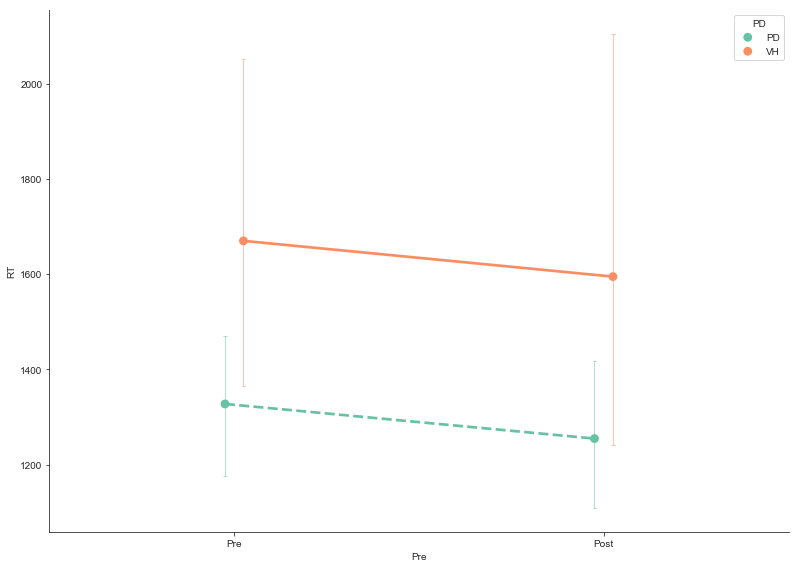

In [300]:
sns.set_style("ticks")
# colours = ["grey", "grey/blue"]
fig = sns.catplot(x="Pre", y="RT", kind="point", hue="PD", scale=1, dodge=True, ci=95, linestyles=["--", "-"],
                  errwidth=0.5, legend_out=False, data=dfPD, capsize=0.01, palette="Set2", height=8, aspect=1.4)

# fig = fig.get_figure()
fig.savefig("ChangeRT2.png")

Plot change in D prime in patients with PD/DLB and hallucinations and those with PD/DLB without hallucinations

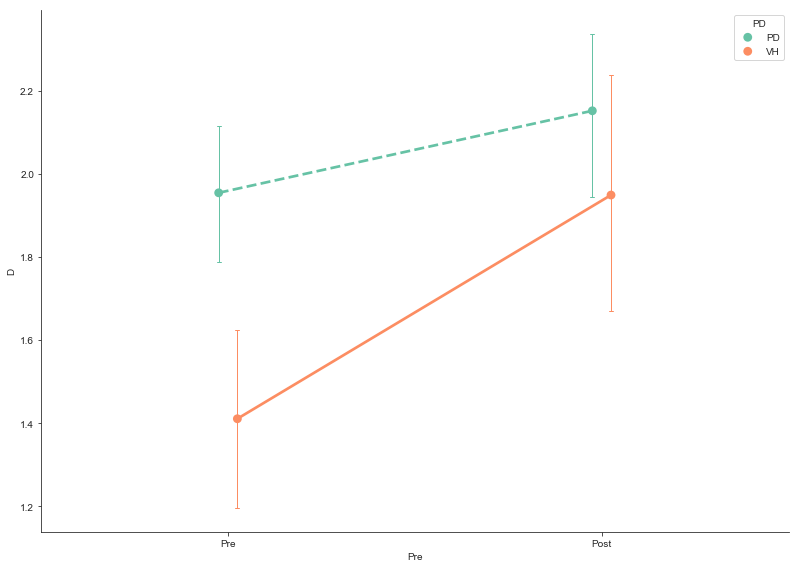

In [13]:
sns.set_style("ticks")
# colours = ["grey", "grey/blue"]
fig = sns.catplot(x="Pre", y="D", kind="point", hue="PD", scale=1, dodge=True, ci=95, linestyles=["--", "-"], 
                  errwidth=1, legend_out=False, data=dfPD, capsize=0.01, palette="Set2", height=8, aspect=1.4)

# fig = fig.get_figure()
fig.savefig("ChangeD2.png")

Plot change in criterion (c)

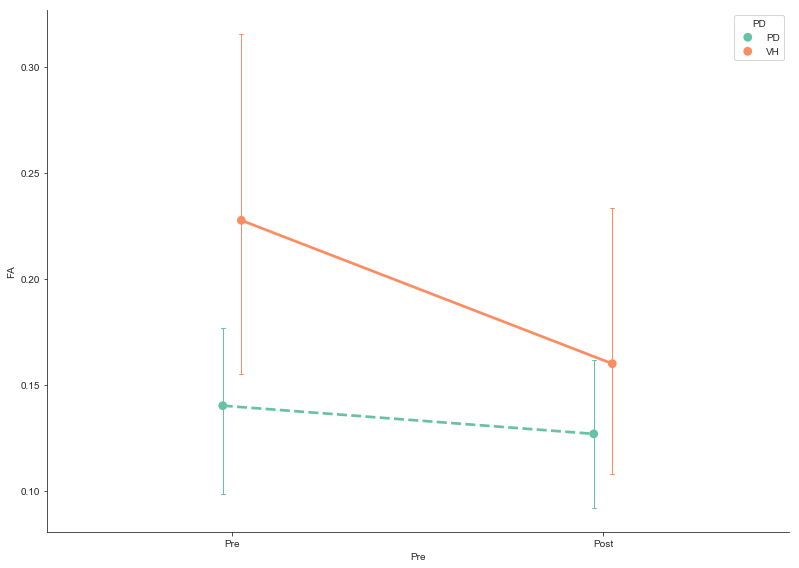

In [15]:
sns.set_style("ticks")
# colours = ["grey", "grey/blue"]
fig = sns.catplot(x="Pre", y="", kind="point", hue="PD", scale=1, dodge=True, ci=95, linestyles=["--", "-"], 
                  errwidth=1, legend_out=False, data=dfPD, capsize=0.01, palette="Set2", height=8, aspect=1.4)

# fig = fig.get_figure()
fig.savefig("ChangeC.png")